# Object Detection with YOLO in PyTorch

In this exercise, you'll use a PyTorch implementation of YOLO to detect objects in an image.

## Install PyTorch
First, let's ensure that PyTorch v1.0 is installed.

In [ ]:
# Install PyTorch
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

We'll also use the OpenCV library

In [ ]:
!pip install opencv-python

## Download and Convert YOLO weights
YOLO is based on the Darknet model architecture - an open-source model written in C. The creators of this model have provided pre-trained weights that were trained on the [Common Objects in Context (COCO) dataset](cocodataset.org) - a common set of sample images for computer vision research.

Run the following cell to download the weights.

> _**Note**: This can take some time to run_

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O yolo_pytorch/yolov3.weights

## Load the Weights into a PyTorch Model

Now that we have the weights, we can load them into a Keras model.

> **Note** The code to implement the Keras model is in **yolo_pytorch/models.py**. Additionally, there are some code files in the **yolo_pytorch/utils** folder that contain functions that are used to assemble and use the model.

In [8]:
import yolo_pytorch.models as models
from yolo_pytorch.utils.utils import *

import os
import sys
import random

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

print("Using PyTorch", torch.__version__)

# Set up model
model_config = 'yolo_pytorch/yolov3.cfg'
img_size = 416
weights = 'yolo_pytorch/yolov3.weights'

model = models.Darknet(model_config, img_size)
models.load_darknet_weights(model, weights)
print(model)

Using PyTorch 1.0.0


## Use the Model to Detect Objects

Now we're ready to use the YOLO model to detect objects in images.

### Create functions to detect and display objects
We'll create a couple of functions:

- **detect_objects**: Submits an image to the model and returns predicted object locations
- **show_objects**: Displays the image with a bounding box fo each detected object.

In [28]:
def detect_objects(model, img):
    
    # Use GPU if available
    if torch.cuda.is_available():
        model.cuda()
        Tensor = torch.cuda.FloatTensor
    else:
        Tensor = torch.FloatTensor
    
    # Set the model to evaluation mode
    model.eval()
    
    # Get scaled width and height
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)

    # Transform the image for prediction
    img_transforms = transforms.Compose([
         transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    # convert image to a Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    # Use the model to detect objects in the image
    with torch.no_grad():
        detections = model(input_img)
        # Eliminate duplicates with non-max suppression
        detections = non_max_suppression(detections, 0.8, 0.4)
    return detections[0]

def show_objects(img, detections):
    
    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if detections is not None:
        # process each instance of each class that was found
        classes = load_classes('yolo_pytorch/coco.names')
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            # Get the class name
            predicted_class = classes[int(cls_pred)]
            
            #We'll display the class name and probability
            label = '{} {:.2f}'.format(predicted_class, cls_conf)
            
            # Set the box dimensions
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            
            # Add a box with the color for this class
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
    plt.axis('off')

    plt.show()
    

### Use the functions with test images
Now we're ready to get some predictions from our test images.

Found 6 objects in 007004.jpg


<Figure size 432x288 with 0 Axes>

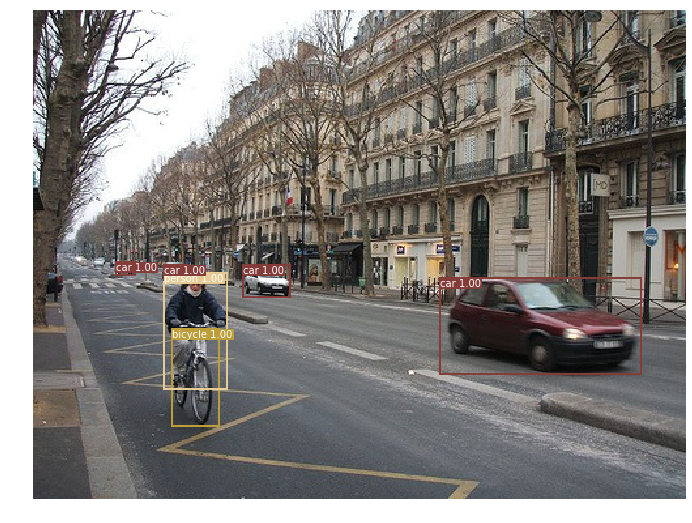

Found 4 objects in 006011.jpg


<Figure size 432x288 with 0 Axes>

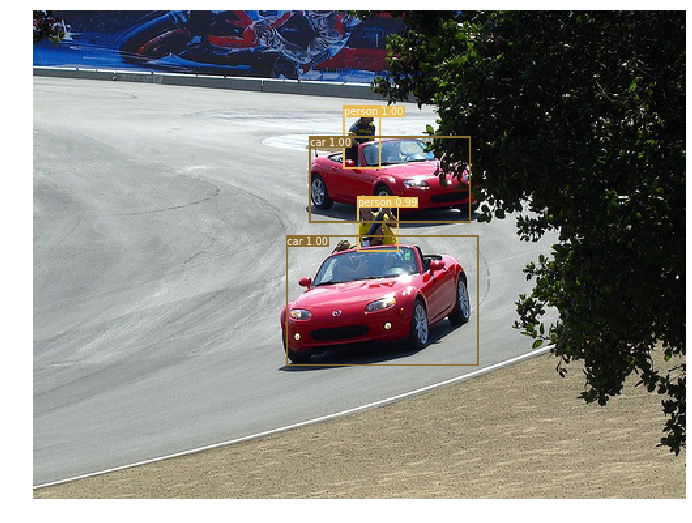

Found 6 objects in 007152.jpg


<Figure size 432x288 with 0 Axes>

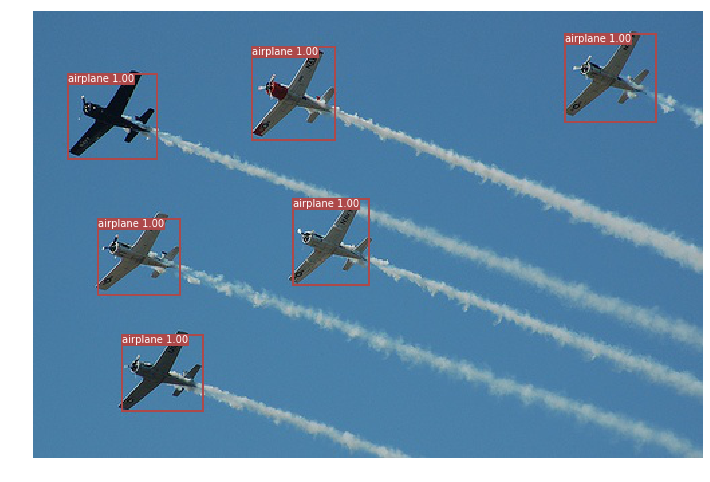

Found 5 objects in 001445.jpg


<Figure size 432x288 with 0 Axes>

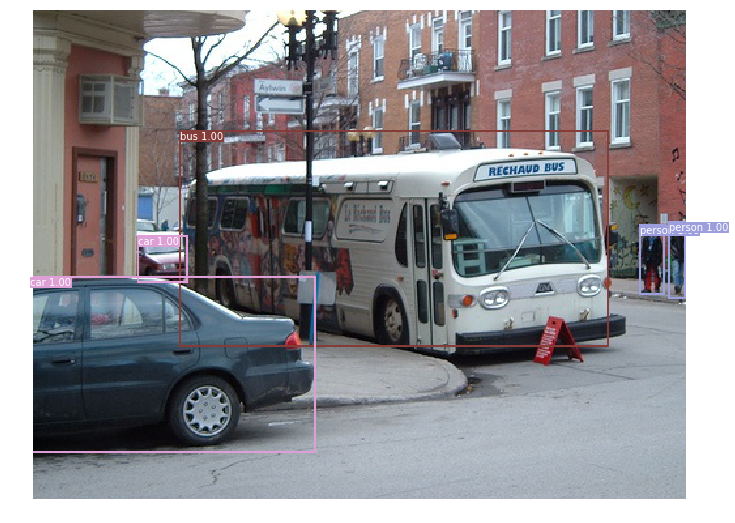

Found 8 objects in 009121.jpg


<Figure size 432x288 with 0 Axes>

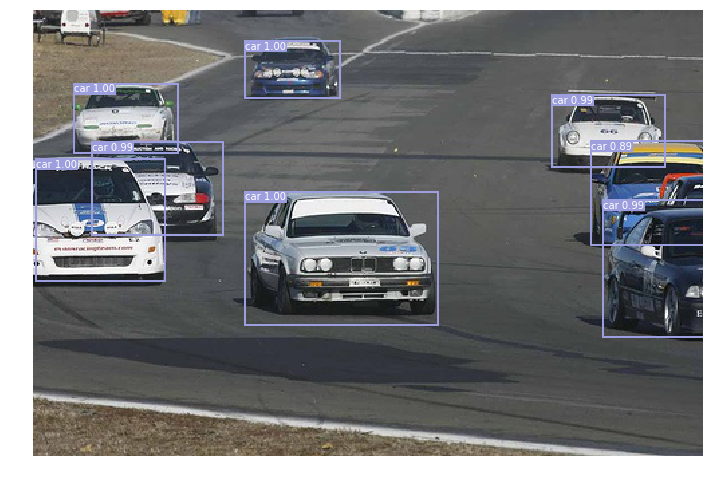

Found 3 objects in 005481.jpg


<Figure size 432x288 with 0 Axes>

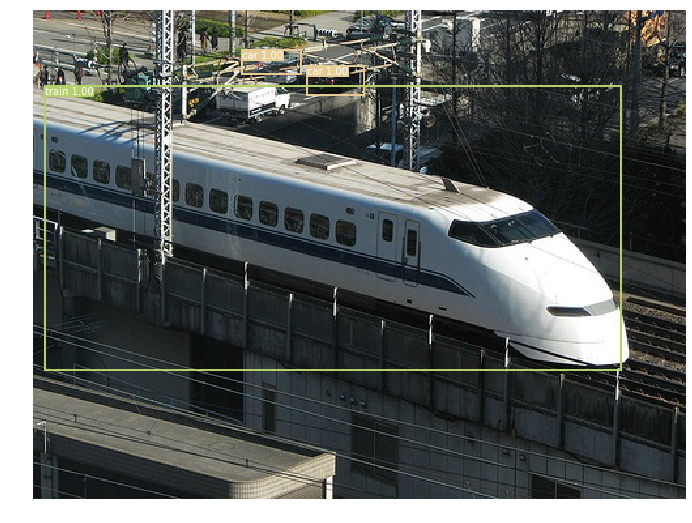

Found 2 objects in 009254.jpg


<Figure size 432x288 with 0 Axes>

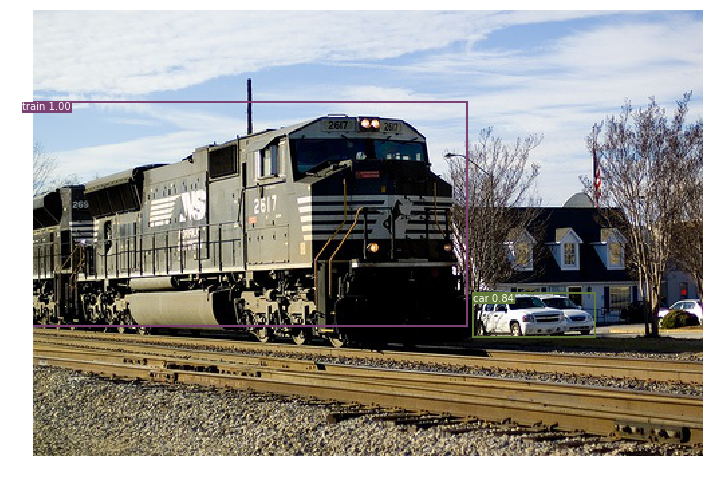

Found 2 objects in 004089.jpg


<Figure size 432x288 with 0 Axes>

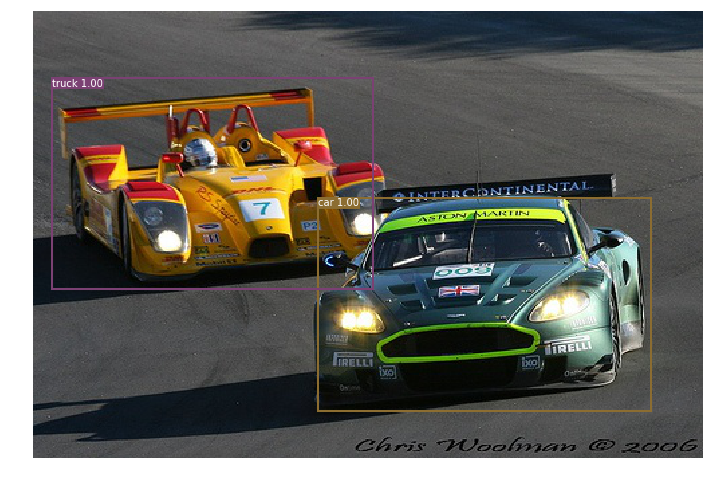

Found 2 objects in 000863.jpg


<Figure size 432x288 with 0 Axes>

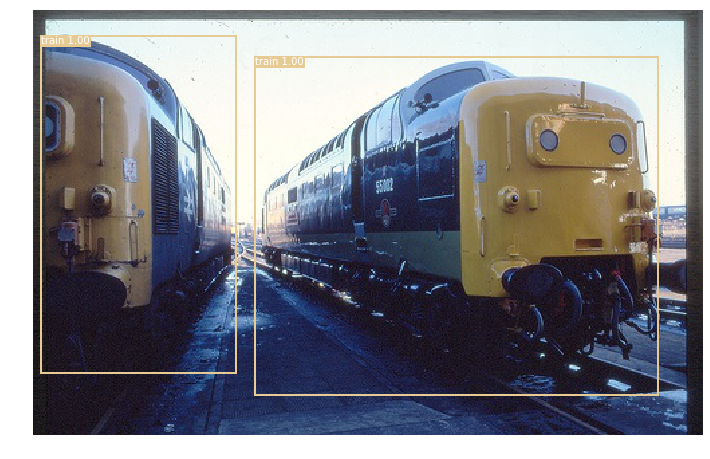

In [33]:
import os
from PIL import Image

test_dir = "test"
for image_file in os.listdir(test_dir):
    
    # Load image
    img_path = os.path.join(test_dir, image_file)
    image = Image.open(img_path)

    # Detect objects in the image
    detections = detect_objects(model, image)

    # How many objects did we detect?
    print('Found {} objects in {}'.format(len(detections), image_file))

    # Display the image with bounding boxes
    show_objects(image, detections)

## Acknowledgements and Citations
The original YOLO documentation is at https://pjreddie.com/darknet/yolo/.

The PyTorch implementation of YOLO used in this exercise is based on the work of Ultralytics at https://github.com/ultralytics/yolov3, with some simplifications.

The test images used in this exercise are from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}
